# Exp 6 - Remove features vs scores
Remove columns one by one to see how the scores change

### Import packages

In [13]:
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from utilities import cal_score, convert_types

### Columns

In [14]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_feats = cols_num + cols_cat + cols_bin

col_target = 'total_price'
col_target_log1p = 'target'

#### Order of columns to be remove

In [15]:
feat_rm = ['XIII_index_500', 'VI_500', 'IX_index_50', 'I_50', 'III_index_50', 'XIV_100', 'X_50', 'VI_index_500', 'VIII_index_50', 'XI_index_1000', 'XIII_250', 'N_500', 'XIII_index_50', 'I_index_1000', 'I_10', 'IV_index_1000', 'VIII_index_1000', 'IX_index_1000', 'I_index_50', 'XIII_10', 'X_index_50', 'IX_50', 'VI_10', 'IX_index_5000', 'XI_index_10000', 'XII_index_1000', 'XIV_index_1000', 'IV_index_5000', 'II_index_1000', 'VII_index_1000', 'XI_index_5000', 'XIII_index_5000', 'II_index_500', 'X_100', 'IX_100', 'XII_index_50', 'XIV_index_500', 'IV_index_50', 'XII_index_500', 'VI_index_50', 'N_5000', 'XIII_100', 'IX_10', 'XIII_index_10000', 'II_index_50', 'XI_index_500', 'V_index_1000', 'VII_index_50', 'VIII_50', 'XIV_10', 'X_10', 'XI_10', 'VI_50', 'III_index_1000', 'XIII_index_1000', 'II_10', 'V_index_500', 'I_100', 'IV_index_500', 'VIII_index_500', 'X_index_500', 'VI_1000', 'VI_index_1000', 'VII_index_500', 'XIV_index_50', 'III_index_500', 'IV_10', 'V_index_50', 'XI_50', 'III_10', 'VII_10', 'XIII_500', 'XIII_50', 'XI_index_50', 'I_index_500', 'XI_100', 'V_10', 'N_10000', 'XII_10', 'I_1000', 'X_index_1000', 'IV_50', 'IV_100', 'VI_100', 'IX_index_500', 'VI_250', 'V_100', 'divorce_rate', 'II_50', 'junior_rate', 'V_50', 'VIII_10', 'II_250', 'XII_50', 'III_100', 'I_250', 'N_1000', 'IV_250', 'XI_500', 'XIV_50', 'IV_500', 'XI_250', 'II_100', 'X_250', 'IX_250', 'III_50', 'III_500', 'X_500', 'VII_50', 'VIII_5000', 'III_250', 'VII_100', 'I_500', 'XII_100', 'II_10000', 'born_rate', 'XIV_250', 'IV_1000', 'III_5000', 'town_area', 'XIII_1000', 'IV_5000', 'marriage_rate', 'XIII_MIN', 'VIII_100', 'X_10000', 'V_250', 'parking_area', 'N_50', 'XIV_500', 'IV_10000', 'death_rate', 'highschool_rate', 'VIII_250', 'VI_MIN', 'II_500', 'XII_250', 'XI_5000', 'VIII_10000', 'I_5000', 'V_1000', 'II_MIN', 'III_1000', 'XII_MIN', 'building_material', 'V_MIN', 'XIV_10000', 'X_5000', 'IX_MIN', 'XIV_1000', 'I_MIN', 'XIV_MIN', 'IX_500', 'XI_MIN', 'town_population_density', 'XII_5000', 'III_MIN', 'IX_5000', 'VIII_500', 'IV_MIN', 'VII_MIN', 'VI_5000', 'III_10000', 'X_MIN', 'X_1000', 'V_500', 'XII_500', 'XII_10000', 'II_5000', 'town_population', 'VIII_MIN', 'IX_10000', 'I_10000', 'II_1000', 'VII_250', 'V_5000', 'building_use', 'bachelor_rate', 'XI_1000', 'VII_5000', 'lat', 'VIII_1000', 'XII_1000', 'IX_1000', 'VII_500', 'city', 'XI_10000', 'V_10000', 'parking_way', 'VII_1000', 'XIV_5000', 'elementary_rate', 'jobschool_rate', 'XIII_5000', 'master_rate', 'lon', 'VI_10000', 'parking_price', 'doc_rate', 'village', 'VII_10000', 'total_floor', 'village_income_median', 'building_type', 'txn_floor', 'txn_dt', 'building_complete_dt', 'XIII_10000', 'land_area', 'town', 'building_area']
print('N of features removed', len(feat_rm))

N of features removed 211


### Read data

In [16]:
df = pd.read_csv('dataset/train.csv', dtype=object)

In [17]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

### Preprocessing

In [18]:
# Convert types
df = convert_types(df, cols_num, col_target=col_target)

# Generate feats (train-test-same feats)
#create_feats(df)

### Target transform

In [19]:
def target_transform(df):  # Add new columns inplace!!
    '''Transform the original target to the target for model to train on'''
    df['log_total_price'] = np.log1p(df['total_price'])
    return df

def target_inverse_transform(df, y_pred):
    '''Inverse transorform the model target to the original target of our problem'''
    y_pred_expm1 = np.expm1(y_pred)
    y_pred_final = np.clip(y_pred_expm1, 0, None)
    return y_pred_final            

In [20]:
df = target_transform(df)

In [21]:
# transformed target fit by the model
col_model_target = 'log_total_price'
#col_model_target = 'total_price'

### Feat engineering

In [22]:
from feature_engineering import CategoricalColumnsEncoder

In [23]:
class FeatureEngineering():
    def __init__(self):
        pass
    
    def fit_transform(self, df, cols_cat, cols_bin):
        df = df.copy()
        # Denote categorical-type
        self.cat_encoder = CategoricalColumnsEncoder(mode='pandas')
        self.cat_encoder.fit_transform(df, cols_cat+cols_bin)
        return df
    
    def transform(self, df):
        df = df.copy()
        self.cat_encoder.transform(df)
        return df

### Grid search

In [24]:
# grid search
lgb_other_params = {'num_boost_round': 10000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,
                   }

#### Remove 45 - 55 features

In [25]:
%%time
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.015,
              'num_leaves': 255,
              'feature_fraction': 0.5,
              'min_data_in_leaf': 5,
              'lambda_l1': 0.1,
              'lambda_l2': 0,
              }

gsearch = {}
gsearch2 = {}
folds = KFold(n_splits=3, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)
    
    # Feature remove
    cols_feats_step = cols_feats.copy()
    
    step_feat_rm = 1
    for n_feat_rm in range(45, 56, step_feat_rm):
        feat_rm_batch = feat_rm[:n_feat_rm]
        print('Remove least', n_feat_rm, 'features upto:', feat_rm_batch[-1])
        cols_feats_step = [c for c in cols_feats_step if c not in feat_rm_batch]
        print('N remaining features:', len(cols_feats_step))

        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train[cols_feats_step], df_train[col_model_target]).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats_step], df_val[col_model_target], reference=lgb_train).construct()

        params = params_fix.copy()

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats_step])

        y_pred_final = target_inverse_transform(df_val, y_pred)

        score = cal_score(df_val['total_price'], y_pred_final)
        score2 = mean_squared_log_error(df_val['total_price'], y_pred_final)
        print(score, score2)
        tuple_params = n_feat_rm
        gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]
        gsearch2[tuple_params] = gsearch2.get(tuple_params, []) + [score2]

# aggregate, sort gsearch results
gsearch_results1 = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results1.sort(key= lambda x: x[0])
gsearch2_results1 = [[key, np.mean(val), val] for key, val in gsearch2.items()]
gsearch2_results1.sort(key= lambda x: x[0])

==== Fold 1 ====
Remove least 45 features upto: II_index_50
N remaining features: 166
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00862526
[4000]	valid_0's mape: 0.00850307
[6000]	valid_0's mape: 0.00847179
[8000]	valid_0's mape: 0.0084615
[10000]	valid_0's mape: 0.00845662
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00845662
5574.865001856178 0.040379839486071926
Remove least 46 features upto: XI_index_500
N remaining features: 165
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00863
[4000]	valid_0's mape: 0.00850528
[6000]	valid_0's mape: 0.00847454
[8000]	valid_0's mape: 0.00846388
[10000]	valid_0's mape: 0.00845904
Did not meet early stopping. Best iteration is:
[9987]	valid_0's mape: 0.00845904
5534.864849392826 0.040557411593380915
Remove least 47 features upto: V_index_1000
N remaining features: 164
Training until validation scores don't improve for 1000 rounds.
[

[4000]	valid_0's mape: 0.00861906
[6000]	valid_0's mape: 0.00858798
[8000]	valid_0's mape: 0.00857698
[10000]	valid_0's mape: 0.00857189
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00857189
5510.8648037378025 0.0420094948085145
Remove least 54 features upto: III_index_1000
N remaining features: 157
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00870551
[4000]	valid_0's mape: 0.00858847
[6000]	valid_0's mape: 0.00855811
[8000]	valid_0's mape: 0.00854595
[10000]	valid_0's mape: 0.00854093
Did not meet early stopping. Best iteration is:
[9998]	valid_0's mape: 0.00854093
5523.865375098552 0.04176510272622243
Remove least 55 features upto: XIII_index_1000
N remaining features: 156
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00877176
[4000]	valid_0's mape: 0.00865063
[6000]	valid_0's mape: 0.00861968
[8000]	valid_0's mape: 0.0086071
[10000]	valid_0's mape: 0.00860159
Did not 

In [26]:
display(gsearch_results1)

[[45,
  5528.197007613715,
  [5574.865001856178, 5492.864744523101, 5516.861276461866]],
 [46,
  5537.197174301834,
  [5534.864849392826, 5522.864979118429, 5553.861694394247]],
 [47,
  5537.530625765317,
  [5554.864915912952, 5516.865315552375, 5540.861645830625]],
 [48,
  5535.5304983229325,
  [5572.864930327295, 5494.864961644069, 5538.861602997434]],
 [49,
  5518.1969352615315,
  [5559.865134888065, 5466.86448628333, 5527.861184613202]],
 [50,
  5541.530596445555,
  [5552.86498432601, 5520.8654143845815, 5550.8613906260725]],
 [51,
  5505.529874055246,
  [5524.86474892536, 5480.864031567135, 5510.860841673246]],
 [52,
  5544.530641014918,
  [5573.864776148716, 5520.865074254275, 5538.862072641765]],
 [53,
  5533.530464619963,
  [5560.864929044257, 5510.8648037378025, 5528.861661077831]],
 [54,
  5525.530556527851,
  [5525.864699842756, 5523.865375098552, 5526.861594642246]],
 [55,
  5498.530064632057,
  [5511.8650054164, 5474.86439746247, 5508.860791017296]]]

In [27]:
display(gsearch2_results1)

[[45,
  0.04159371023103297,
  [0.040379839486071926, 0.04210879474649908, 0.042292496460527886]],
 [46,
  0.04162602270349673,
  [0.040557411593380915, 0.04202240758832372, 0.04229824892878556]],
 [47,
  0.041743705088053674,
  [0.040769803524388186, 0.041991710179037044, 0.04246960156073579]],
 [48,
  0.041446714136998374,
  [0.040410779524175267, 0.04170977949187867, 0.04221958339494118]],
 [49,
  0.04151336644503217,
  [0.04019326224654146, 0.04198465372382345, 0.042362183364731576]],
 [50,
  0.04143388342737902,
  [0.04025327918015319, 0.04178051142443061, 0.042267859677553254]],
 [51,
  0.04170987596137823,
  [0.04056198480926631, 0.04219875835630946, 0.0423688847185589]],
 [52,
  0.041592156474374635,
  [0.04064979687024859, 0.04206568312239518, 0.04206098943048014]],
 [53,
  0.04151468427536698,
  [0.04042083379856042, 0.0420094948085145, 0.04211372421902603]],
 [54,
  0.04157965123501728,
  [0.04065342126837405, 0.04176510272622243, 0.04232042971045536]],
 [55,
  0.04149185849

In [28]:
def plot_rm_feature_scores(gs_results):
    plt.plot([row[0] for row in gs_results], [row[1] for row in gs_results])
    plt.plot([row[0] for row in gs_results], [row[2][0] for row in gs_results], alpha=0.5)
    plt.plot([row[0] for row in gs_results], [row[2][1] for row in gs_results], alpha=0.5)
    plt.plot([row[0] for row in gs_results], [row[2][2] for row in gs_results], alpha=0.5)
    plt.xlabel('N features removed')
    plt.ylabel('score')
    plt.grid(); plt.show()

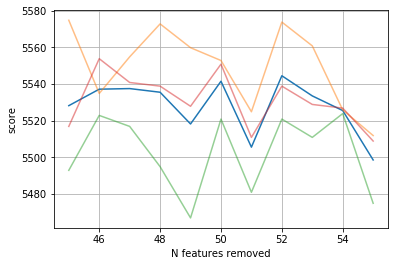

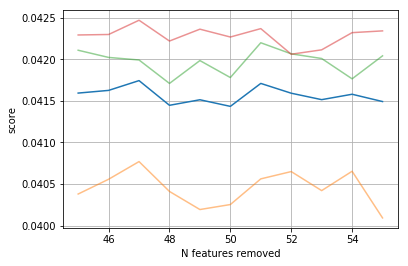

In [29]:
plot_rm_feature_scores(gsearch_results1)
plot_rm_feature_scores(gsearch2_results1)

#### Remove 18 - 28 features

In [30]:
%%time
params_fix2 = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.015,
              'num_leaves': 255,
              'feature_fraction': 0.5,
              'min_data_in_leaf': 5,
              'lambda_l1': 0.1,
              'lambda_l2': 0.1,
              }

gsearch = {}
gsearch2 = {}
folds = KFold(n_splits=3, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)
    
    # Feature remove
    cols_feats_step = cols_feats.copy()
    
    step_feat_rm = 1
    for n_feat_rm in range(18, 29, step_feat_rm):
        feat_rm_batch = feat_rm[:n_feat_rm]
        print('Remove least', n_feat_rm, 'features upto:', feat_rm_batch[-1])
        cols_feats_step = [c for c in cols_feats_step if c not in feat_rm_batch]
        print('N remaining features:', len(cols_feats_step))

        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train[cols_feats_step], df_train[col_model_target]).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats_step], df_val[col_model_target], reference=lgb_train).construct()

        params = params_fix2.copy()

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats_step])

        y_pred_final = target_inverse_transform(df_val, y_pred)

        score = cal_score(df_val['total_price'], y_pred_final)
        score2 = mean_squared_log_error(df_val['total_price'], y_pred_final)
        print(score, score2)
        tuple_params = n_feat_rm
        gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]
        gsearch2[tuple_params] = gsearch2.get(tuple_params, []) + [score2]

# aggregate, sort gsearch results
gsearch_results2 = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results2.sort(key= lambda x: x[0])
gsearch2_results2 = [[key, np.mean(val), val] for key, val in gsearch2.items()]
gsearch2_results2.sort(key= lambda x: x[0])

==== Fold 1 ====
Remove least 18 features upto: IX_index_1000
N remaining features: 193
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00861451
[4000]	valid_0's mape: 0.00849298
[6000]	valid_0's mape: 0.00846328
[8000]	valid_0's mape: 0.00845292
[10000]	valid_0's mape: 0.00844832
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00844832
5534.8651266010365 0.04038025896322785
Remove least 19 features upto: I_index_50
N remaining features: 192
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00866229
[4000]	valid_0's mape: 0.00853698
[6000]	valid_0's mape: 0.00850483
[8000]	valid_0's mape: 0.0084937
[10000]	valid_0's mape: 0.00848882
Did not meet early stopping. Best iteration is:
[9987]	valid_0's mape: 0.00848882
5519.864417440262 0.040550586027173645
Remove least 20 features upto: XIII_10
N remaining features: 191
Training until validation scores don't improve for 1000 rounds.
[20

[2000]	valid_0's mape: 0.00873332
[4000]	valid_0's mape: 0.00860976
[6000]	valid_0's mape: 0.00857842
[8000]	valid_0's mape: 0.00856762
[10000]	valid_0's mape: 0.0085619
Did not meet early stopping. Best iteration is:
[9996]	valid_0's mape: 0.0085619
5488.865131107558 0.04174123430555543
Remove least 27 features upto: XIV_index_1000
N remaining features: 184
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00873332
[4000]	valid_0's mape: 0.00860976
[6000]	valid_0's mape: 0.00857842
[8000]	valid_0's mape: 0.00856762
[10000]	valid_0's mape: 0.0085619
Did not meet early stopping. Best iteration is:
[9996]	valid_0's mape: 0.0085619
5488.865131107558 0.04174123430555543
Remove least 28 features upto: IV_index_5000
N remaining features: 183
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00871292
[4000]	valid_0's mape: 0.008589
[6000]	valid_0's mape: 0.00855672
[8000]	valid_0's mape: 0.00854466
[10000]	valid_0's

In [31]:
display(gsearch_results2)

[[18,
  5524.530609206596,
  [5534.8651266010365, 5522.864999031114, 5515.861701987637]],
 [19,
  5509.530233533375,
  [5519.864417440262, 5487.864981155491, 5520.861302004374]],
 [20,
  5517.863630051527,
  [5529.86504669048, 5488.864749803437, 5534.861093660664]],
 [21,
  5501.863221024539,
  [5522.8647711143185, 5481.864223723277, 5500.860668236021]],
 [22,
  5546.864193165759,
  [5594.864973334109, 5522.865595699588, 5522.862010463583]],
 [23,
  5526.863922757624,
  [5540.864776456598, 5488.865131107558, 5550.861860708716]],
 [24,
  5526.863922757624,
  [5540.864776456598, 5488.865131107558, 5550.861860708716]],
 [25,
  5526.863922757624,
  [5540.864776456598, 5488.865131107558, 5550.861860708716]],
 [26,
  5526.863922757624,
  [5540.864776456598, 5488.865131107558, 5550.861860708716]],
 [27,
  5526.863922757624,
  [5540.864776456598, 5488.865131107558, 5550.861860708716]],
 [28,
  5508.197187179428,
  [5500.864696134539, 5492.865340147324, 5530.861525256419]]]

In [32]:
display(gsearch2_results2)

[[18,
  0.04151586324930232,
  [0.04038025896322785, 0.04190440531483807, 0.042262925469841055]],
 [19,
  0.04162332743185266,
  [0.040550586027173645, 0.041833251211531364, 0.04248614505685297]],
 [20,
  0.041555022668671206,
  [0.04032139233890258, 0.04202231205283374, 0.04232136361427732]],
 [21,
  0.04166552833897339,
  [0.04034278702927925, 0.042289918445767155, 0.042363879541873775]],
 [22,
  0.04153776582368771,
  [0.04080132317287463, 0.041667444511545304, 0.0421445297866432]],
 [23,
  0.04150896149693666,
  [0.04065252504676326, 0.04174123430555543, 0.042133125138491295]],
 [24,
  0.04150896149693666,
  [0.04065252504676326, 0.04174123430555543, 0.042133125138491295]],
 [25,
  0.04150896149693666,
  [0.04065252504676326, 0.04174123430555543, 0.042133125138491295]],
 [26,
  0.04150896149693666,
  [0.04065252504676326, 0.04174123430555543, 0.042133125138491295]],
 [27,
  0.04150896149693666,
  [0.04065252504676326, 0.04174123430555543, 0.042133125138491295]],
 [28,
  0.041425656

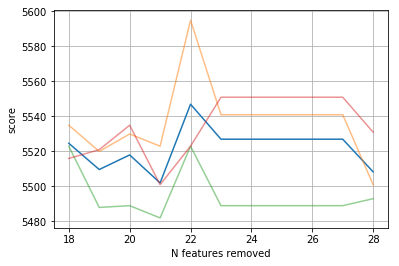

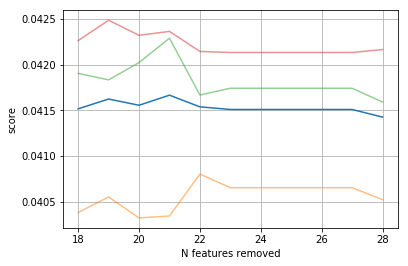

In [33]:
plot_rm_feature_scores(gsearch_results2)
plot_rm_feature_scores(gsearch2_results2)

#### Remove 1 - 10 features

In [34]:
%%time
params_fix3 = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.015,
              'num_leaves': 255,
              'feature_fraction': 0.5,
              'min_data_in_leaf': 5,
              'lambda_l1': 0.1,
              'lambda_l2': 0,
              }

gsearch = {}
gsearch2 = {}
folds = KFold(n_splits=3, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)
    
    # Feature remove
    cols_feats_step = cols_feats.copy()
    
    step_feat_rm = 1
    for n_feat_rm in range(1, 11, step_feat_rm):
        feat_rm_batch = feat_rm[:n_feat_rm]
        print('Remove least', n_feat_rm, 'features upto:', feat_rm_batch[-1])
        cols_feats_step = [c for c in cols_feats_step if c not in feat_rm_batch]
        print('N remaining features:', len(cols_feats_step))

        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train[cols_feats_step], df_train[col_model_target]).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats_step], df_val[col_model_target], reference=lgb_train).construct()

        params = params_fix3.copy()

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats_step])

        y_pred_final = target_inverse_transform(df_val, y_pred)

        score = cal_score(df_val['total_price'], y_pred_final)
        score2 = mean_squared_log_error(df_val['total_price'], y_pred_final)
        print(score, score2)
        tuple_params = n_feat_rm
        gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]
        gsearch2[tuple_params] = gsearch2.get(tuple_params, []) + [score2]

# aggregate, sort gsearch results
gsearch_results3 = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results3.sort(key= lambda x: x[0])
gsearch2_results3 = [[key, np.mean(val), val] for key, val in gsearch2.items()]
gsearch2_results3.sort(key= lambda x: x[0])

==== Fold 1 ====
Remove least 1 features upto: XIII_index_500
N remaining features: 210
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00863435
[4000]	valid_0's mape: 0.00851634
[6000]	valid_0's mape: 0.0084866
[8000]	valid_0's mape: 0.00847577
[10000]	valid_0's mape: 0.00847111
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00847111
5572.864775063605 0.04052927619092015
Remove least 2 features upto: VI_500
N remaining features: 209
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00861289
[4000]	valid_0's mape: 0.00849232
[6000]	valid_0's mape: 0.00846205
[8000]	valid_0's mape: 0.00845123
[10000]	valid_0's mape: 0.00844678
Did not meet early stopping. Best iteration is:
[9996]	valid_0's mape: 0.00844677
5550.865137441896 0.04033743454898239
Remove least 3 features upto: IX_index_50
N remaining features: 208
Training until validation scores don't improve for 1000 rounds.
[2000]	v

[4000]	valid_0's mape: 0.00862151
[6000]	valid_0's mape: 0.00859161
[8000]	valid_0's mape: 0.00857932
[10000]	valid_0's mape: 0.00857355
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00857355
5506.864758491032 0.04190083287528771
==== Fold 3 ====
Remove least 1 features upto: XIII_index_500
N remaining features: 210
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00878023
[4000]	valid_0's mape: 0.00865302
[6000]	valid_0's mape: 0.00861809
[8000]	valid_0's mape: 0.00860574
[10000]	valid_0's mape: 0.0086001
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.0086001
5532.861325117652 0.04226496693685656
Remove least 2 features upto: VI_500
N remaining features: 209
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00873504
[4000]	valid_0's mape: 0.00860866
[6000]	valid_0's mape: 0.00857563
[8000]	valid_0's mape: 0.00856341
[10000]	valid_0's mape: 0.00855847
Di

In [35]:
display(gsearch_results3)
display(gsearch2_results3)

[[1,
  5537.197012150561,
  [5572.864775063605, 5505.864936270423, 5532.861325117652]],
 [2,
  5524.864088443818,
  [5550.865137441896, 5496.865241482913, 5526.861886406648]],
 [3,
  5524.86404785325,
  [5552.864887200053, 5480.865387254302, 5540.861869105393]],
 [4,
  5528.86378087839,
  [5536.86473235062, 5502.864980373298, 5546.861629911253]],
 [5,
  5509.863531971663,
  [5520.864965538016, 5488.864414555816, 5519.861215821156]],
 [6,
  5529.197130552368,
  [5556.865024132825, 5489.864925828897, 5540.861441695382]],
 [7,
  5527.530449727041,
  [5542.865080380608, 5512.8649072297685, 5526.861361570745]],
 [8,
  5503.530180744875,
  [5550.865065670099, 5456.864320391528, 5502.861156172998]],
 [9,
  5530.197026934368,
  [5546.864768067502, 5490.8648908094565, 5552.861421926144]],
 [10,
  5528.530586512938,
  [5538.865091815424, 5506.864758491032, 5539.861909232358]]]

[[1,
  0.04158920302511467,
  [0.04052927619092015, 0.0419733659475673, 0.04226496693685656]],
 [2,
  0.04147805218410281,
  [0.04033743454898239, 0.041909442702300015, 0.04218727930102604]],
 [3,
  0.04159919810993235,
  [0.04073655422326724, 0.04191174770991432, 0.0421492923966155]],
 [4,
  0.041592688265701686,
  [0.04053425884210022, 0.0420730669354112, 0.04217073901959363]],
 [5,
  0.041617690904025215,
  [0.040323102661091015, 0.042168556545808734, 0.0423614135051759]],
 [6,
  0.04156388537765463,
  [0.040467814315779706, 0.04193713337852234, 0.04228670843866187]],
 [7,
  0.04150610202155613,
  [0.04040863648464258, 0.04183356583254773, 0.04227610374747806]],
 [8,
  0.04154909125376673,
  [0.040237643651958366, 0.04209847210683673, 0.04231115800250509]],
 [9,
  0.04173192415013005,
  [0.04061448330134415, 0.0420926634723064, 0.04248862567673962]],
 [10,
  0.04140569614633743,
  [0.04034445368610273, 0.04190083287528771, 0.04197180187762185]]]

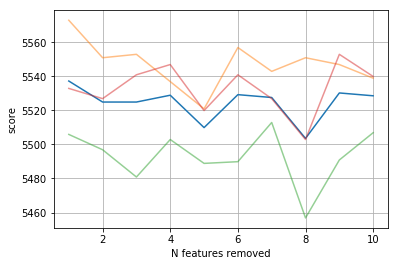

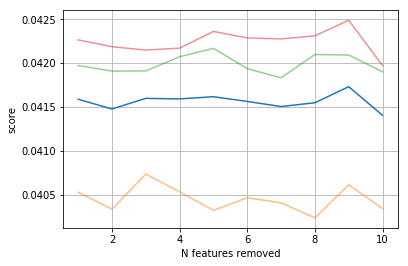

In [36]:
plot_rm_feature_scores(gsearch_results3)
plot_rm_feature_scores(gsearch2_results3)

#### Remove 95-105 features

In [37]:
%%time
params_fix4 = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.015,
              'num_leaves': 255,
              'feature_fraction': 0.5,
              'min_data_in_leaf': 5,
              'lambda_l1': 0.1,
              'lambda_l2': 0.1,
              }

gsearch = {}
gsearch2 = {}
folds = KFold(n_splits=3, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)
    
    # Feature remove
    cols_feats_step = cols_feats.copy()
    
    step_feat_rm = 1
    for n_feat_rm in range(95, 105, step_feat_rm):
        feat_rm_batch = feat_rm[:n_feat_rm]
        print('Remove least', n_feat_rm, 'features upto:', feat_rm_batch[-1])
        cols_feats_step = [c for c in cols_feats_step if c not in feat_rm_batch]
        print('N remaining features:', len(cols_feats_step))

        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train[cols_feats_step], df_train[col_model_target]).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats_step], df_val[col_model_target], reference=lgb_train).construct()

        params = params_fix4.copy()

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats_step])

        y_pred_final = target_inverse_transform(df_val, y_pred)

        score = cal_score(df_val['total_price'], y_pred_final)
        score2 = mean_squared_log_error(df_val['total_price'], y_pred_final)
        print(score, score2)
        tuple_params = n_feat_rm
        gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]
        gsearch2[tuple_params] = gsearch2.get(tuple_params, []) + [score2]

# aggregate, sort gsearch results
gsearch_results4 = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results4.sort(key= lambda x: x[0])
gsearch2_results4 = [[key, np.mean(val), val] for key, val in gsearch2.items()]
gsearch2_results4.sort(key= lambda x: x[0])

==== Fold 1 ====
Remove least 95 features upto: III_100
N remaining features: 116
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00859587
[4000]	valid_0's mape: 0.0084697
[6000]	valid_0's mape: 0.00843927
[8000]	valid_0's mape: 0.00842836
[10000]	valid_0's mape: 0.00842327
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00842326
5576.86527693136 0.04016314666269955
Remove least 96 features upto: I_250
N remaining features: 115
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00861072
[4000]	valid_0's mape: 0.00848254
[6000]	valid_0's mape: 0.00844931
[8000]	valid_0's mape: 0.00843757
[10000]	valid_0's mape: 0.00843254
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00843254
5548.865362914917 0.04023515481697848
Remove least 97 features upto: N_1000
N remaining features: 114
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's m

[6000]	valid_0's mape: 0.00865773
[8000]	valid_0's mape: 0.00864518
[10000]	valid_0's mape: 0.00863932
Did not meet early stopping. Best iteration is:
[9996]	valid_0's mape: 0.00863931
5468.863681526585 0.04255366812721324
==== Fold 3 ====
Remove least 95 features upto: III_100
N remaining features: 116
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00872969
[4000]	valid_0's mape: 0.00860311
[6000]	valid_0's mape: 0.0085713
[8000]	valid_0's mape: 0.00855884
[10000]	valid_0's mape: 0.00855342
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00855342
5518.862000013477 0.042041446992222384
Remove least 96 features upto: I_250
N remaining features: 115
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00874172
[4000]	valid_0's mape: 0.00861482
[6000]	valid_0's mape: 0.00858391
[8000]	valid_0's mape: 0.00857215
[10000]	valid_0's mape: 0.00856649
Did not meet early stopping. Best iterati

In [38]:
display(gsearch_results4)

[[95,
  5535.530805016636,
  [5576.86527693136, 5510.865138105072, 5518.862000013477]],
 [96,
  5537.864113405779,
  [5548.865362914917, 5524.865253552155, 5539.861723750263]],
 [97,
  5533.530573717773,
  [5548.864999187493, 5518.865254008378, 5532.861467957448]],
 [98,
  5515.196716946517,
  [5561.865075407574, 5468.86396696805, 5514.861108463928]],
 [99,
  5535.197279100538,
  [5563.865190690209, 5504.865044633541, 5536.861601977864]],
 [100,
  5536.197176691388,
  [5567.865145650106, 5504.864935124741, 5535.861449299317]],
 [101,
  5514.863810840804,
  [5556.864903145306, 5486.865093385691, 5500.8614359914145]],
 [102,
  5522.19725285364,
  [5530.864912448242, 5508.865245379483, 5526.861600733193]],
 [103,
  5515.196938989378,
  [5549.865013311959, 5480.864603778085, 5514.86119987809]],
 [104,
  5503.529899045996,
  [5518.864929817065, 5468.863681526585, 5522.861085794339]]]

In [39]:
display(gsearch2_results4)

[[95,
  0.04134274480228051,
  [0.04016314666269955, 0.041823640751919584, 0.042041446992222384]],
 [96,
  0.041333148060346714,
  [0.04023515481697848, 0.041704211934768566, 0.04206007742929311]],
 [97,
  0.04144538300605637,
  [0.0403444581402752, 0.04178952125011628, 0.042202169627777626]],
 [98,
  0.04152928932202762,
  [0.040265021130001674, 0.04204850810773248, 0.042274338728348675]],
 [99,
  0.04160563369144371,
  [0.04046961784438914, 0.042021300588869465, 0.04232598264107252]],
 [100,
  0.04153422776438345,
  [0.040569081919172564, 0.041854066924395604, 0.042179534449582196]],
 [101,
  0.04163580065287826,
  [0.040580599092131873, 0.041934893563072805, 0.04239190930343009]],
 [102,
  0.04138639746362291,
  [0.04027470155675199, 0.04182269874366732, 0.04206179209044941]],
 [103,
  0.04164487101208884,
  [0.04065699726985085, 0.04197112624581743, 0.04230648952059823]],
 [104,
  0.04177841378445877,
  [0.040380424276319986, 0.04255366812721324, 0.04240114894984311]]]

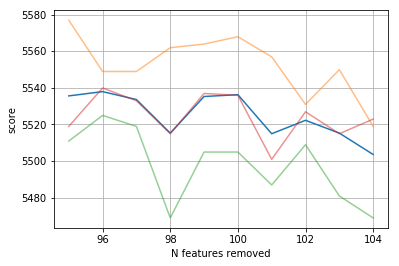

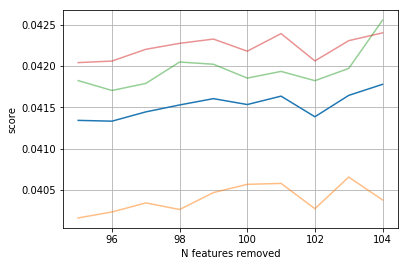

In [40]:
plot_rm_feature_scores(gsearch_results4)
plot_rm_feature_scores(gsearch2_results4)

#### Remove 151-161 features

In [45]:
%%time
params_fix5 = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.015,
              'num_leaves': 255,
              'feature_fraction': 0.5,
              'min_data_in_leaf': 5,
              'lambda_l1': 0.1,
              'lambda_l2': 0.01,
              }

gsearch = {}
gsearch2 = {}
folds = KFold(n_splits=3, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)
    
    # Feature remove
    cols_feats_step = cols_feats.copy()
    
    step_feat_rm = 2
    for n_feat_rm in range(141, 161, step_feat_rm):
        feat_rm_batch = feat_rm[:n_feat_rm]
        print('Remove least', n_feat_rm, 'features upto:', feat_rm_batch[-1])
        cols_feats_step = [c for c in cols_feats_step if c not in feat_rm_batch]
        print('N remaining features:', len(cols_feats_step))

        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train[cols_feats_step], df_train[col_model_target]).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats_step], df_val[col_model_target], reference=lgb_train).construct()

        params = params_fix5.copy()

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats_step])

        y_pred_final = target_inverse_transform(df_val, y_pred)

        score = cal_score(df_val['total_price'], y_pred_final)
        score2 = mean_squared_log_error(df_val['total_price'], y_pred_final)
        print(score, score2)
        tuple_params = n_feat_rm
        gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]
        gsearch2[tuple_params] = gsearch2.get(tuple_params, []) + [score2]

# aggregate, sort gsearch results
gsearch_results5 = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results5.sort(key= lambda x: x[0])
gsearch2_results5 = [[key, np.mean(val), val] for key, val in gsearch2.items()]
gsearch2_results5.sort(key= lambda x: x[0])

==== Fold 1 ====
Remove least 141 features upto: V_1000
N remaining features: 70
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00866061
[4000]	valid_0's mape: 0.00852235
[6000]	valid_0's mape: 0.0084868
[8000]	valid_0's mape: 0.00847447
[10000]	valid_0's mape: 0.00846864
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00846864
5550.864757847212 0.04029479647943881
Remove least 143 features upto: III_1000
N remaining features: 68
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00865253
[4000]	valid_0's mape: 0.00851618
[6000]	valid_0's mape: 0.00848238
[8000]	valid_0's mape: 0.00847099
[10000]	valid_0's mape: 0.00846566
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00846566
5542.864793727133 0.04041133945658849
Remove least 145 features upto: building_material
N remaining features: 66
Training until validation scores don't improve for 1000 rounds.
[200

[4000]	valid_0's mape: 0.00870862
[6000]	valid_0's mape: 0.00866929
[8000]	valid_0's mape: 0.00865575
[10000]	valid_0's mape: 0.00864863
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00864863
5466.863251907408 0.04258780234181254
==== Fold 3 ====
Remove least 141 features upto: V_1000
N remaining features: 70
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00880072
[4000]	valid_0's mape: 0.00866592
[6000]	valid_0's mape: 0.00862997
[8000]	valid_0's mape: 0.00861639
[10000]	valid_0's mape: 0.00861007
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00861007
5498.861029401372 0.04215746243787871
Remove least 143 features upto: III_1000
N remaining features: 68
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0087589
[4000]	valid_0's mape: 0.00862256
[6000]	valid_0's mape: 0.00858545
[8000]	valid_0's mape: 0.0085707
[10000]	valid_0's mape: 0.00856417
Did no

In [46]:
display(gsearch_results5)

[[141,
  5494.529955693087,
  [5550.864757847212, 5433.864079830672, 5498.861029401372]],
 [143,
  5527.1970865744925,
  [5542.864793727133, 5493.864876966149, 5544.861589030196]],
 [145,
  5530.197005210186,
  [5562.8648230104, 5492.864682055772, 5534.861510564385]],
 [147,
  5525.862983924356,
  [5542.864174635188, 5489.8640400043, 5544.860737133584]],
 [149,
  5528.196831930196,
  [5546.8644901736825, 5492.86481518305, 5544.861190433855]],
 [151,
  5515.196306486604,
  [5552.864427145187, 5476.863862752704, 5515.86062956192]],
 [153,
  5538.196683392877,
  [5540.864051971338, 5499.864619631438, 5573.861378575854]],
 [155,
  5512.529724286306,
  [5556.8644005213355, 5455.8639107485515, 5524.860861589035]],
 [157,
  5536.862977169104,
  [5569.863669769428, 5466.863738137506, 5573.861523600377]],
 [159,
  5508.195761234751,
  [5548.863578144088, 5466.863251907408, 5508.860453652759]]]

In [47]:
display(gsearch2_results5)

[[141,
  0.04148443280930605,
  [0.04029479647943881, 0.04200103951060063, 0.04215746243787871]],
 [143,
  0.04139102238837881,
  [0.04041133945658849, 0.04184342460732904, 0.0419183031012189]],
 [145,
  0.041565215540054795,
  [0.04045359092341315, 0.042057911475354044, 0.042184144221397185]],
 [147,
  0.041699316716516534,
  [0.040470424728452734, 0.04234015035143813, 0.04228737506965873]],
 [149,
  0.041744653249991936,
  [0.04079530127091912, 0.04205876752039415, 0.04237989095866253]],
 [151,
  0.041741294511598866,
  [0.04049015643930562, 0.042336927823056064, 0.042396799272434914]],
 [153,
  0.04158696606845901,
  [0.0407848436237453, 0.04190167635942514, 0.042074378222206596]],
 [155,
  0.04165982185638018,
  [0.04045046984129114, 0.04217787004298792, 0.04235112568486148]],
 [157,
  0.04197811888373723,
  [0.04110056972177748, 0.042664698505973334, 0.04216908842346088]],
 [159,
  0.041899191056294166,
  [0.04081732818388369, 0.04258780234181254, 0.04229244264318627]]]

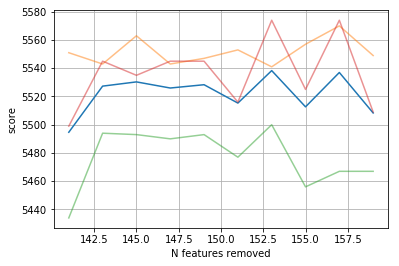

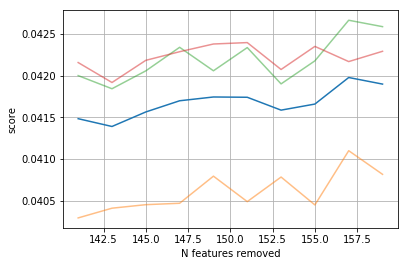

In [48]:
plot_rm_feature_scores(gsearch_results5)
plot_rm_feature_scores(gsearch2_results5)

#### Plot together

##### Hit rate

In [33]:
#gsearch_results100 = [[100, 5530.530463485084, [5567.865183219395, 5500.8648255894295, 5522.8613816464285]]]

In [49]:
gsearch_results_all = gsearch_results1 + gsearch_results2 + gsearch_results3 + gsearch_results4 + gsearch_results5
gsearch_results_all.sort(key= lambda x: x[0])

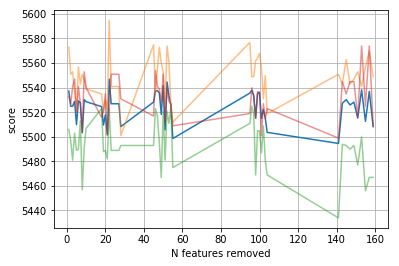

In [50]:
plot_rm_feature_scores(gsearch_results_all)

##### MSLE

In [51]:
gsearch2_results_all = gsearch2_results1 + gsearch2_results2 + gsearch2_results3 + gsearch2_results4 + gsearch2_results5
gsearch2_results_all.sort(key= lambda x: x[0])

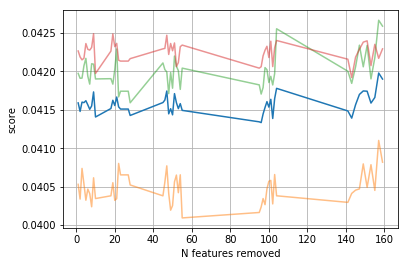

In [52]:
plot_rm_feature_scores(gsearch2_results_all)

### Conclusion

Baseline Best params:  
   ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5),  
   ('lambda_l1', 0.1),  
   ('lambda_l2', 0)  
  
Baseline Best scores: 5515.529915334645  
[5532.864763855017, 5514.864357360793, 5498.860624788125]

Removing 50 features is better than removing 23 features